# Testing CAMB-EDE
Author: João Victor S. Rebouças, November 2021.

This is a notebook for testing our CAMB modification including EDE models. Download the modified CAMB version at https://github.com/CoupleDE-UNESP/CAMB-EDE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import sys, platform, os
import time
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# If you have many CAMB versions at your disposal, it's always useful to check which CAMB is being used.

Using CAMB 1.3.4 installed at /home/joaov/CAMB/CAMB-EDE/camb


In [2]:
# Aesthetic Matplotlib configs
%matplotlib inline
#
import matplotlib
import matplotlib.pyplot as plt
#
font = {'size':16, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [3]:
# Energy density unit conversion
Mpc = 3.085678e22
c = 2.99792458e8
G = 6.6738e-11
kappa = 8 * np.pi * G
hplanck = 6.62606896e-34
hbar = hplanck/2/np.pi
Tpl = np.sqrt(kappa*hbar/c**5)
energyunitconversion = Mpc**2/(c**2 * Tpl**2)
# Potentials:
rocknroll = 1
axionede = 2

## $\Lambda$CDM Baseline
For the purpose of observing the effect of EDE in the CMB, we calculate the $C_\ell$ in a $\Lambda$CDM cosmology.

In [5]:
lcdmcosmology = camb.set_params(# Background
                                H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                # Neutrinos
                                omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                # Initial Power Spectrum
                                As = 2.100549e-09, ns = 0.9660499, 
                                YHe = 0.246, WantTransfer=True)
lcdmresults = camb.get_results(lcdmcosmology)
lcdmcls = lcdmresults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
ks = lcdmresults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
lcdmpks = lcdmresults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]

## Testing $z_c$, $f_{de}(z_c)$ parametrization in Rock 'n' Roll (Monomial Potential)
The rock 'n' Roll model (detailed description in https://arxiv.org/abs/1904.01016) has the potential:
 - $V(\phi) = V_0 \left(\frac{\phi}{M_{pl}}\right)^{2n}$
Our free parameters are $V_0, \phi_I$. But for MCMCs we want to use $z_c$ and $f_{de}(z_c)$, the energy density peak redshift and fraction as parameters. $n$ is a "fixed" parameter: we usually adjust it to see whether is makes too big of a difference in the results. In the Rock 'n' Roll model, we change from $\{V_0, \phi_I\}$ to $\{z_c, f_{de}\}$ so there are no more free parameters.

Let's test this parametrization by controlling $z_c$ with fixed $f_{de}(z_c)$

In [5]:
# Varying the peak redshift
zc_targets = [3000, 5000, 10000, 20000]
fde_zc_target = 0.2
legends = [r'$z_c = $'+ str(x) for x in zc_targets]
cls = []
pks = []
phis = []
omegaphis = []
wphis = []
# Calling CAMB and getting results
for zc_target in zc_targets:
    edecosmology = camb.set_params(# Background
                                    thetastar = 0.0104, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Adding an Early Dark Energy component with the monomial potential
                                    dark_energy_model = 'EarlyDarkEnergy', which_potential = rocknroll,
                                    n = 3, use_zc=True, zc = zc_target, fde_zc = fde_zc_target,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True, npoints=200)
    ederesults = camb.get_results(edecosmology)
    # Get quantities from CAMB
    scales = np.array(ederesults.Params.DarkEnergy.sampled_a)
    phis.append(np.array(ederesults.Params.DarkEnergy.phi_a))
    wphis.append(ederesults.get_dark_energy_rho_w(scales)[1])
    omegaphis.append(ederesults.get_Omega('de', z = 1/scales - 1))
    cls.append(ederesults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0])
    ks = ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pks.append(ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2])

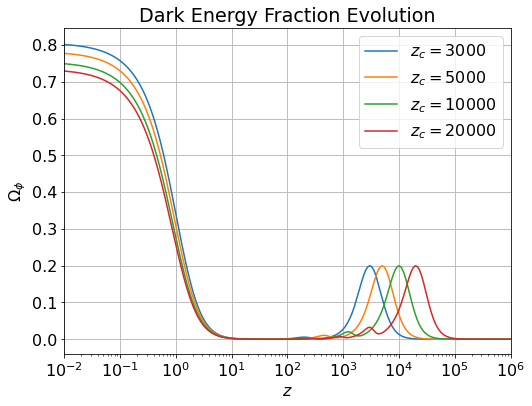

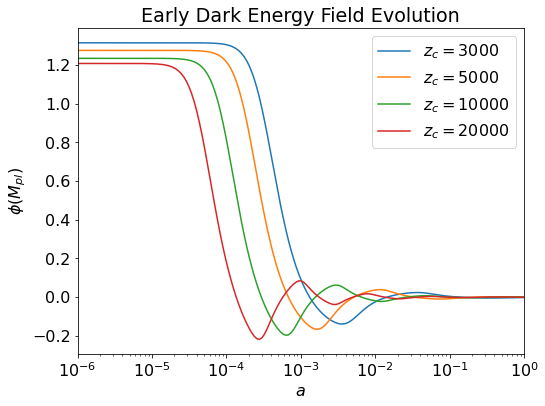

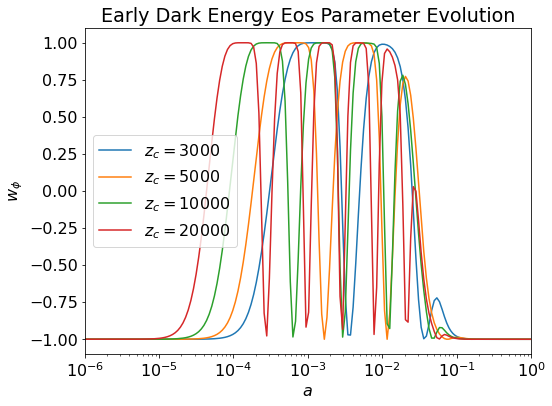

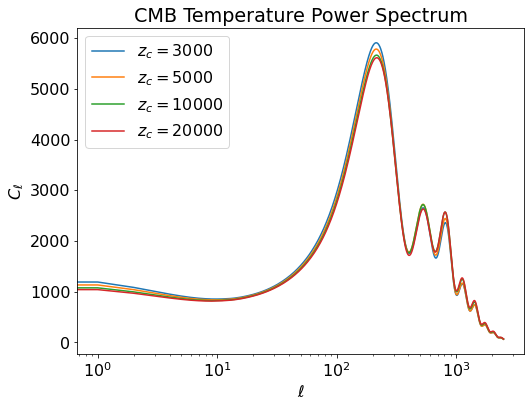

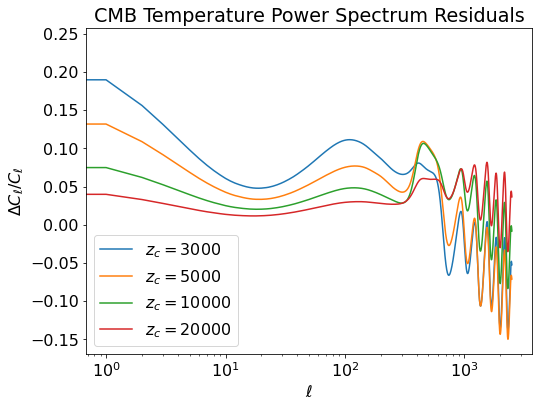

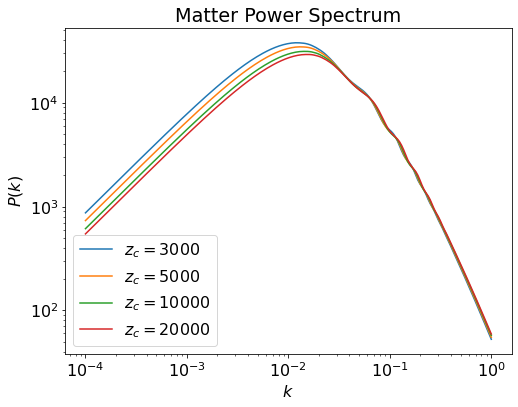

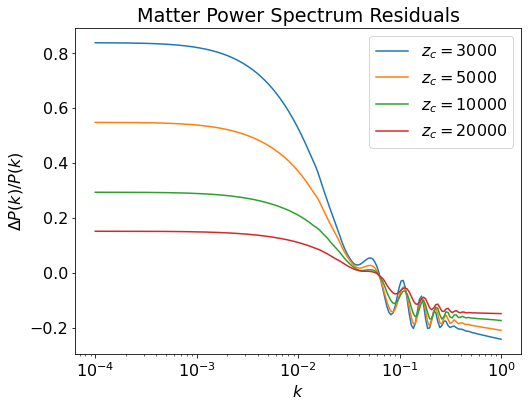

In [6]:
# Plotting background quantities
redshifts = 1/scales - 1
for omegaphi in omegaphis:
    plt.plot(redshifts, omegaphi)
plt.xscale('log')
plt.xlim([10**(-2), 10**6])
plt.title('Dark Energy Fraction Evolution')
plt.xlabel(r'$z$')
plt.ylabel(r'$\Omega_\phi$')
plt.legend(legends)
plt.grid()
plt.savefig('rocknroll_5_omegaphis.pdf')
plt.show()

for phi in phis:
    plt.plot(scales, phi)
plt.xscale('log')
plt.xlim([10**(-6), 1])
plt.title('Early Dark Energy Field Evolution')
plt.xlabel(r'$a$')
plt.ylabel(r'$\phi(M_{pl})$')
plt.legend(legends)
plt.savefig('rocknroll_5_phi.pdf')
plt.show()

for wphi in wphis:
    plt.plot(scales, wphi)
plt.xscale('log')
plt.xlim([10**(-6), 1])
plt.title('Early Dark Energy Eos Parameter Evolution')
plt.xlabel(r'$a$')
plt.ylabel(r'$w_\phi$')
plt.legend(legends)
plt.savefig('rocknroll_5_wphis.pdf')
plt.show()

# Plotting Cls
for cl in cls:
    plt.plot(cl[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend(legends)
plt.savefig('rocknroll_5_cls.pdf')
plt.show()
# Plotting Cl residuals
for cl in cls:
    plt.plot((cl[2:]-lcdmcls[2:])/lcdmcls[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum Residuals')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / C_\ell$')
plt.legend(legends)
plt.savefig('rocknroll_5_cls_res.pdf')
plt.show()
# Plotting Matter power spectra
for pk in pks:
    plt.plot(ks, pk[0,:])
plt.xscale('log')
plt.yscale('log')
plt.title('Matter Power Spectrum')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.legend(legends)
plt.savefig('rocknroll_5_pks.pdf')
plt.show()
# Plotting Pk residuals
for pk in pks:
    plt.plot(ks, (pk[0,:] - lcdmpks[0,:])/lcdmpks[0,:])
plt.xscale('log')
# plt.yscale('log')
plt.title('Matter Power Spectrum Residuals')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta P(k) / P(k)$')
plt.legend(legends)
plt.savefig('rocknroll_5_pks_res.pdf')
plt.show()

### Now, let's vary $f_{de}(z_c)$

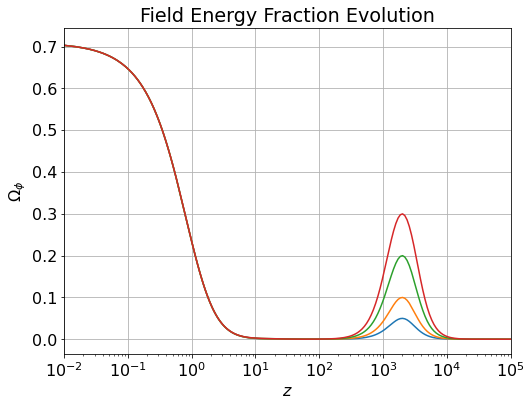

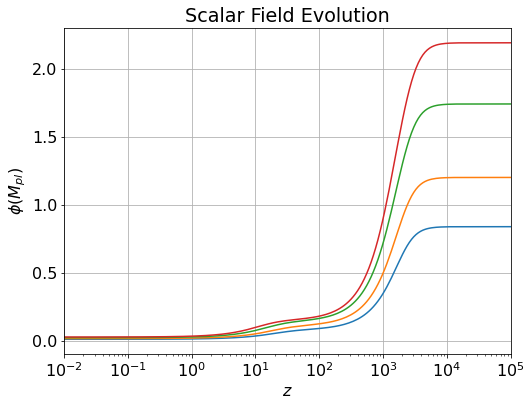

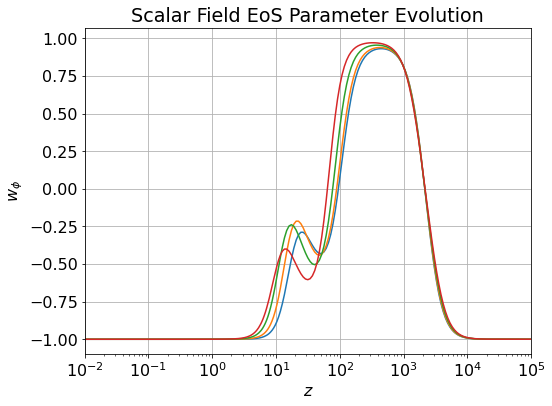

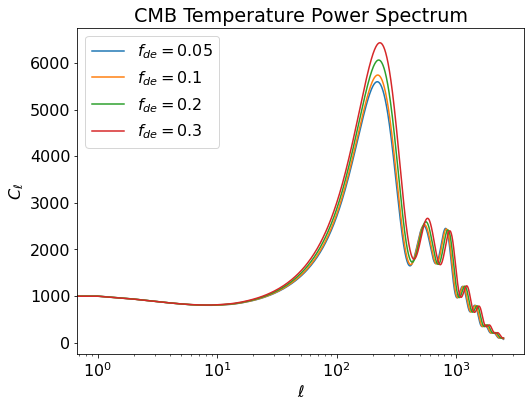

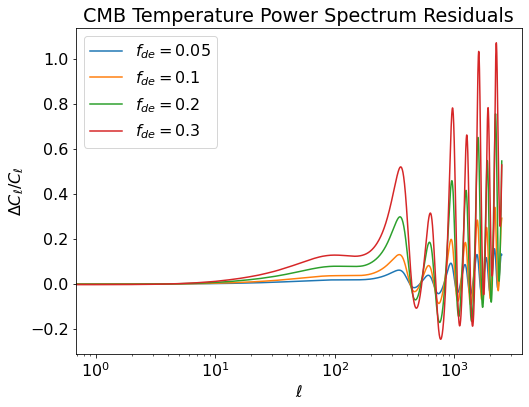

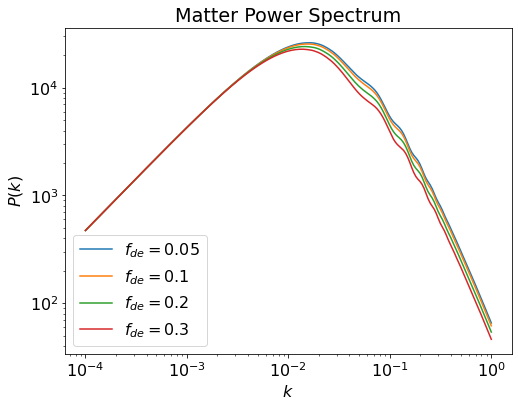

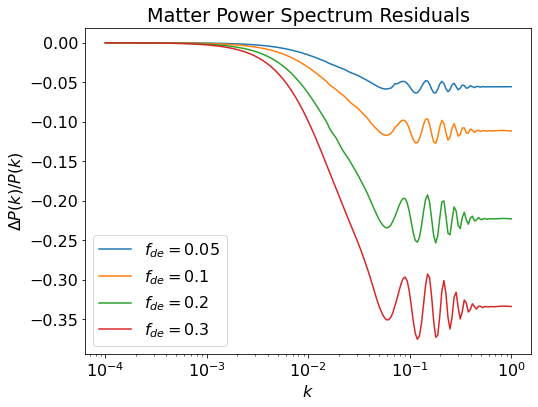

In [7]:
# Configuring plots
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

titles = ['Field Energy Fraction Evolution', 'Scalar Field Evolution', 'Scalar Field EoS Parameter Evolution']
ylabels = [r'$\Omega_\phi$', r'$\phi (M_{pl})$', r'$w_\phi$']
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xscale('log')
    ax.grid()
    ax.set_title(titles[i])
    ax.set_xlim([10**-2,100000])
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(ylabels[i])

fde_targets = [0.05, 0.1, 0.2, 0.3]
legends = [r'$f_{de} = $'+str(x) for x in fde_targets]
cls = []
pks = []

# Calling CAMB
for fde_target in fde_targets:
    edecosmology = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Early Dark Energy with Rock 'n' Roll
                                    dark_energy_model = 'EarlyDarkEnergy', which_potential = rocknroll,
                                    n = 4, use_zc=True, zc = 2000, fde_zc = fde_target,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True, npoints=200)
    ederesults = camb.get_results(edecosmology)
    # Getting results
    scales = np.array(ederesults.Params.DarkEnergy.sampled_a)
    phis = np.array(ederesults.Params.DarkEnergy.phi_a)
    rho_phis, wphis = ederesults.get_dark_energy_rho_w(scales)
    fde = ederesults.get_Omega('de', z = 1/scales - 1)
    cls.append(ederesults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0])
    ks = ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pks.append(ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2])
    # Plotting
    ax2.plot(1/scales-1, phis)
    ax1.plot(1/scales-1, fde)
    ax3.plot(1/scales-1, wphis)
plt.show()

# Plotting Cls
for cl in cls:
    plt.plot(cl[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend(legends)
plt.show()
# Plotting Cl residuals
for cl in cls:
    plt.plot((cl[2:]-lcdmcls[2:])/lcdmcls[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum Residuals')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / C_\ell$')
plt.legend(legends)
plt.show()
# Plotting Matter power spectra
for pk in pks:
    plt.plot(ks, pk[0,:])
plt.xscale('log')
plt.yscale('log')
plt.title('Matter Power Spectrum')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.legend(legends)
plt.show()
# Plotting Pk residuals
for pk in pks:
    plt.plot(ks, (pk[0,:] - lcdmpks[0,:])/lcdmpks[0,:])
plt.xscale('log')
# plt.yscale('log')
plt.title('Matter Power Spectrum Residuals')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta P(k) / P(k)$')
plt.legend(legends)
plt.show()

## Testing AxionEDE
Let's run the same tests for the AxionEDE model (detailed description in https://arxiv.org/pdf/2003.07355.pdf), which uses the potential $V(\phi) = m^2 f^2 \left[1 - \cos\left(\frac{\phi}{f}\right)\right]^n$
In the AxionEDE model, we change $\{m,f\}$ to $\{z_c, f_{de}\}$, so we still have $\phi_I$ as a parameter. A common replacement for $\phi_I$ is $\theta_I = \phi_I/f$.

CAMBError: Error in Fortran called from calc_transfer:
You need to normalize realistically to use lensing. See http://cosmocoffee.info/viewtopic.php?t=94

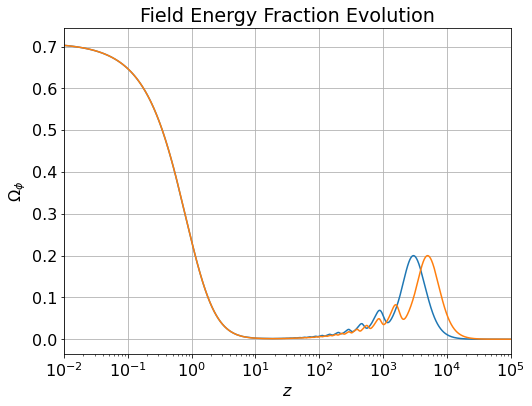

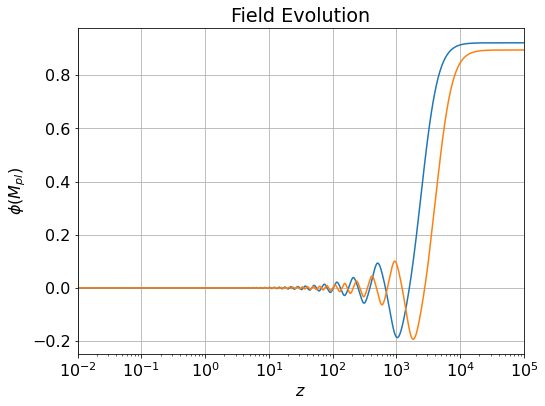

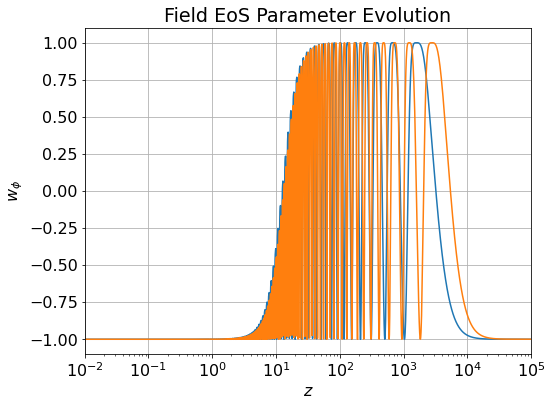

In [9]:
# Configuring plots
fig5, ax5 = plt.subplots()
fig1, ax1 = plt.subplots()
fig4, ax4 = plt.subplots()
ax5.set_xscale('log')
ax5.set_xlim([10**-2,100000])
ax5.set_xlabel(r'$z$')
ax5.set_ylabel(r'$\Omega_\phi$')
ax5.set_title('Field Energy Fraction Evolution')
ax5.grid()
ax1.set_xscale('log')
ax1.set_xlabel(r'$z$')
ax1.set_xlim([10**-2,100000])
ax1.set_ylabel(r'$\phi (M_{pl})$')
ax1.set_title('Field Evolution')
ax1.grid()
ax4.set_xscale('log')
ax4.set_xlim([10**-2,100000])
ax4.set_xlabel(r'$z$')
ax4.set_ylabel(r'$w_\phi$')
ax4.set_title('Field EoS Parameter Evolution')
ax4.grid()


# Varying the peak redshift
zc_targets = [3000, 5000, 10000, 20000, 50000]
cls = []
pks = []
for zc_target in zc_targets:
    edecosmology = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Early Dark Energy with Rock 'n' Roll
                                    dark_energy_model = 'EarlyDarkEnergy', which_potential = axionede,
                                    n = 2, use_zc=True, zc = zc_target, fde_zc = 0.2, theta_i = 0.3,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True, 
                                    AccuracyBoost=1.1)
    ederesults = camb.get_results(edecosmology)
    scales = np.array(ederesults.Params.DarkEnergy.sampled_a)
    phis = np.array(ederesults.Params.DarkEnergy.phi_a)
    rho_phis, wphis = ederesults.get_dark_energy_rho_w(scales)
    fde = ederesults.get_Omega('de', z = 1/scales - 1)
    cls.append(ederesults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0])
    ks = ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pks.append(ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2])
    # Plots
    ax1.plot(1/scales-1, phis)
    ax5.plot(1/scales-1, fde)
    ax4.plot(1/scales-1, wphis)
plt.show()

# Plotting Cls
for cl in cls:
    plt.plot(cl[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()
# Plotting Cl residuals
for cl in cls:
    plt.plot((cl[2:]-lcdmcls[2:])/lcdmcls[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum Residuals')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / C_\ell$')
plt.show()
# Plotting Matter power spectra
for pk in pks:
    plt.plot(ks, pk[0,:])
plt.xscale('log')
plt.yscale('log')
plt.title('Matter Power Spectrum')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.show()
# Plotting Pk residuals
for pk in pks:
    plt.plot(ks, (pk[0,:] - lcdmpks[0,:])/lcdmpks[0,:])
plt.xscale('log')
# plt.yscale('log')
plt.title('Matter Power Spectrum Residuals')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta P(k) / P(k)$')
plt.show()

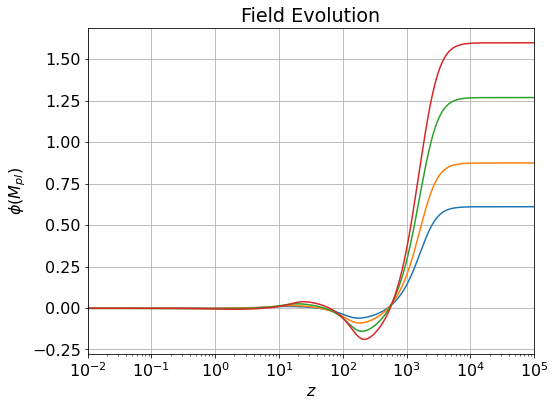

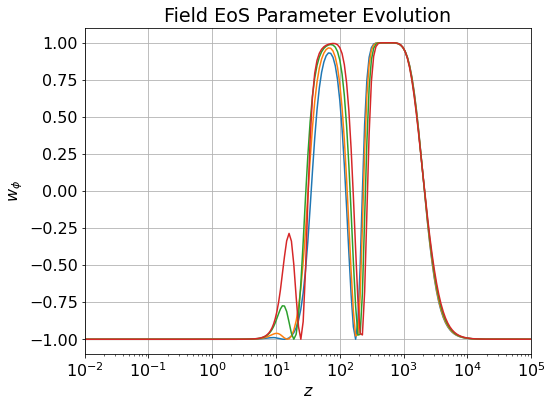

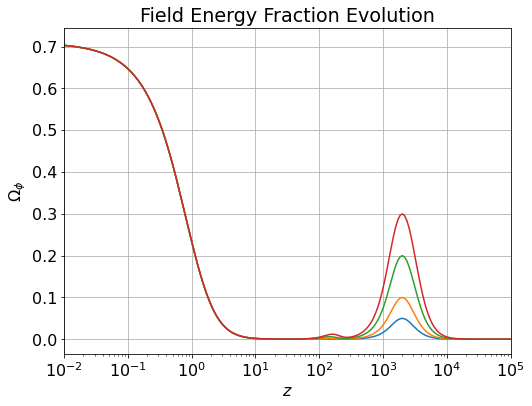

In [9]:
# Configuring plots
fig1, ax1 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
ax1.set_xscale('log')
ax1.set_xlabel(r'$z$')
ax1.set_xlim([10**-2,100000])
ax1.set_ylabel(r'$\phi (M_{pl})$')
ax1.set_title('Field Evolution')
ax1.grid()
ax4.set_xscale('log')
ax4.set_xlim([10**-2,100000])
ax4.set_xlabel(r'$z$')
ax4.set_ylabel(r'$w_\phi$')
ax4.set_title('Field EoS Parameter Evolution')
ax4.grid()
ax5.set_xscale('log')
ax5.set_xlim([10**-2,100000])
ax5.set_xlabel(r'$z$')
ax5.set_ylabel(r'$\Omega_\phi$')
ax5.set_title('Field Energy Fraction Evolution')
ax5.grid()

fde_targets = [0.05, 0.1, 0.2, 0.3]
cls = []
pks = []
for fde_target in fde_targets:
    quintessencecosmology = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Early Dark Energy with Rock 'n' Roll
                                    dark_energy_model = 'EarlyDarkEnergy', which_potential = axionede,
                                    n = 3, use_zc=True, zc = 2000, fde_zc = fde_target, theta_i = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    quintessenceresults = camb.get_results(quintessencecosmology)
    scales = np.array(quintessenceresults.Params.DarkEnergy.sampled_a)
    phis = np.array(quintessenceresults.Params.DarkEnergy.phi_a)
    phidots = np.array(quintessenceresults.Params.DarkEnergy.phidot_a)
    rho_phis, wphis = quintessenceresults.get_dark_energy_rho_w(scales)
    fde = quintessenceresults.get_Omega('de', z = 1/scales - 1)
    # Plots
    ax1.plot(1/scales-1, phis)
    ax5.plot(1/scales-1, fde)
    ax4.plot(1/scales-1, wphis)
plt.show()

## Effective Fluid Model
Finally, we study the effective fluid approximation for the axionEDE model, explained in https://arxiv.org/pdf/1811.04083.pdf. Instead of a scalar field, we use a fluid parametrization, modelling $w(a)$ by a transition from $w = -1$ at early times to $w > 0$ after a certain treshold $z_c$.

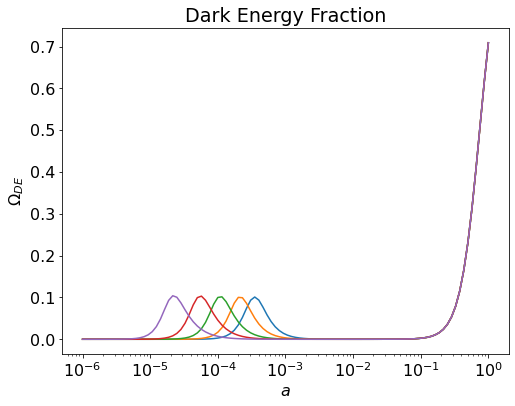

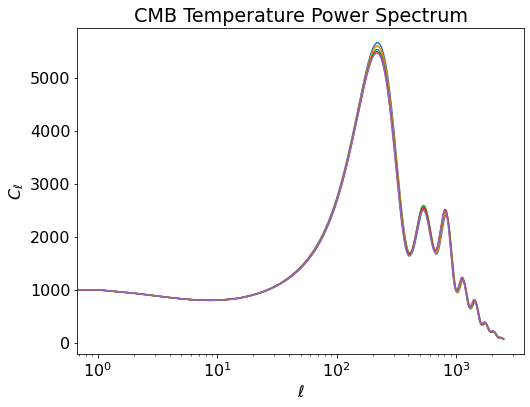

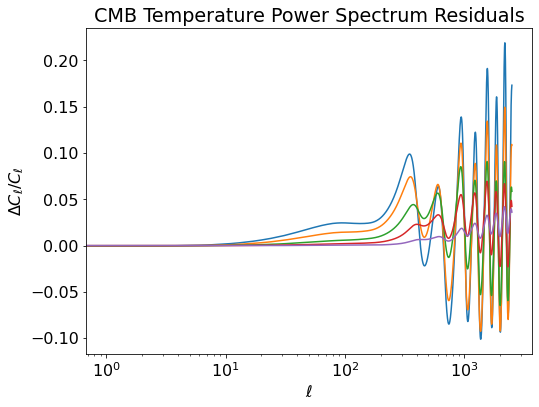

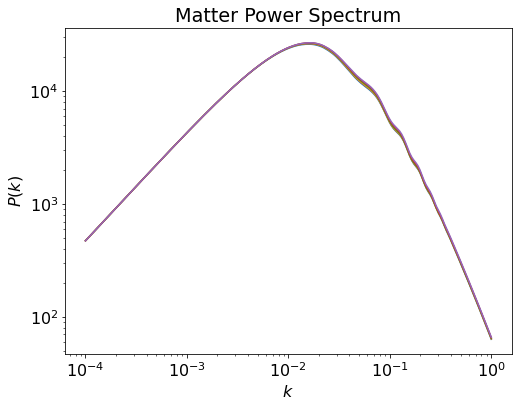

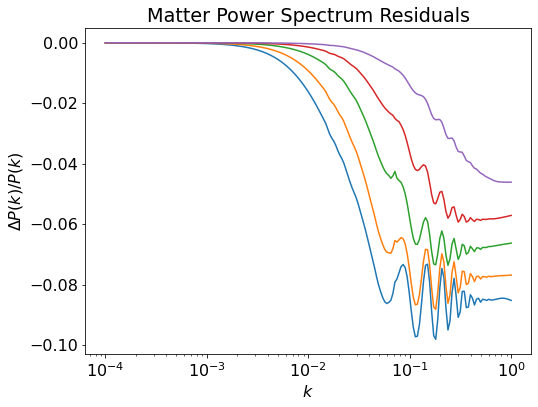

In [14]:
# Varying the peak redshift
zc_targets = [3000, 5000, 10000, 20000, 50000]
cls = []
pks = []
f_des = []
scales = np.logspace(-6, 0, 100)
for zc_target in zc_targets:
    edecosmology = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Early Dark Energy with Rock 'n' Roll
                                    dark_energy_model = 'AxionEffectiveFluid',
                                    zc = zc_target, fde_zc = 0.1, w_n = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    ederesults = camb.get_results(edecosmology)
    rho_de, w_de = ederesults.get_dark_energy_rho_w(scales)
    f_des.append(ederesults.get_Omega('de', z = 1/scales - 1))
    cls.append(ederesults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0])
    ks = ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pks.append(ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2])

for f_de in f_des:
    plt.plot(scales, f_de)
    plt.xscale('log')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$\Omega_{DE}$')
    plt.title('Dark Energy Fraction')
plt.show()

# Plotting Cls
for cl in cls:
    plt.plot(cl[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()
# Plotting Cl residuals
for cl in cls:
    plt.plot((cl[2:]-lcdmcls[2:])/lcdmcls[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum Residuals')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / C_\ell$')
plt.show()
# Plotting Matter power spectra
for pk in pks:
    plt.plot(ks, pk[0,:])
plt.xscale('log')
plt.yscale('log')
plt.title('Matter Power Spectrum')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.show()
# Plotting Pk residuals
for pk in pks:
    plt.plot(ks, (pk[0,:] - lcdmpks[0,:])/lcdmpks[0,:])
plt.xscale('log')
# plt.yscale('log')
plt.title('Matter Power Spectrum Residuals')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta P(k) / P(k)$')
plt.show()

## Testing for errors

In [ ]:
# Varying the max contribution
# zc_targets = [3000, 5000, 10000, 20000]
zc_targets = [7000]
fde_zc_target = 0.05
legends = [r'$z_c = $'+ str(x) for x in zc_targets]
cls = []
pks = []
phis = []
omegaphis = []
wphis = []
# Calling CAMB and getting results
for zc_target in zc_targets:
    npoints = 7500
    edecosmology = camb.set_params(# Background
                                    thetastar = 0.0104, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Adding an Early Dark Energy component with the monomial potential
                                    dark_energy_model = 'EarlyDarkEnergy', which_potential = 1,
                                    n = 2, use_zc=True, zc = zc_target, fde_zc = fde_zc_target,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True, npoints=npoints)
    try:
        ederesults = camb.get_results(edecosmology)
    except camb.CAMBError as err:
        print(err)
        print("Error with npoints=%.2f, zc = %.2f, fde=%.2f" % (npoints, zc_target, fde_zc_target))
    # Get quantities from CAMB
    scales = np.array(ederesults.Params.DarkEnergy.sampled_a)
    phis.append(np.array(ederesults.Params.DarkEnergy.phi_a))
    wphis.append(ederesults.get_dark_energy_rho_w(scales)[1])
    omegaphis.append(ederesults.get_Omega('de', z = 1/scales - 1))
    cls.append(ederesults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0])
    ks = ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pks.append(ederesults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2])

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =    1.0710532858296106E-107   14.604654246533483     
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE] calc_zc_fde: seems like there is no energy density peak
 [EDE] (V0,initial_phi) =                        NaN                       NaN
 [EDE]

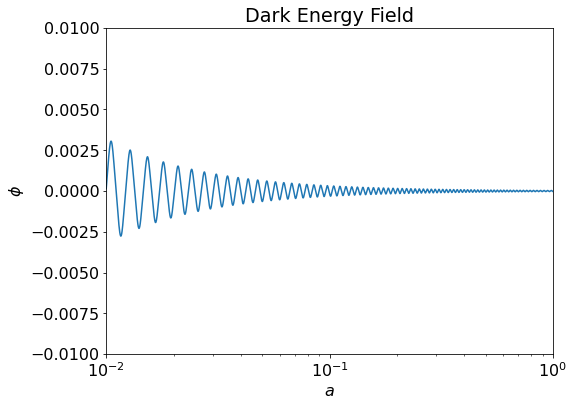

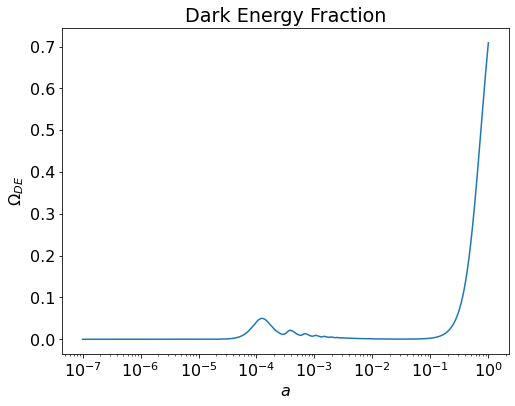

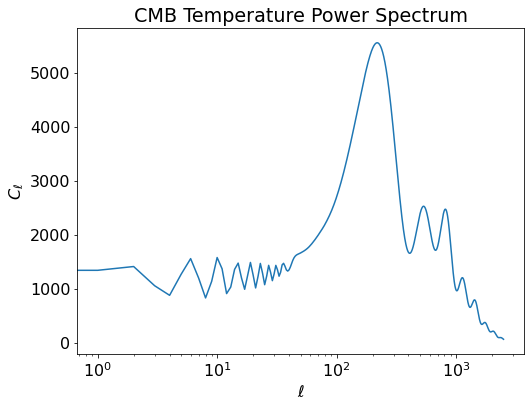

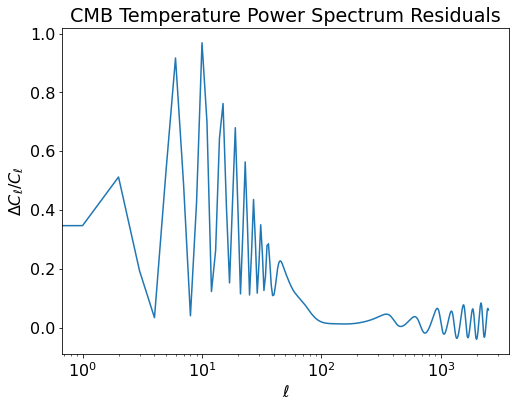

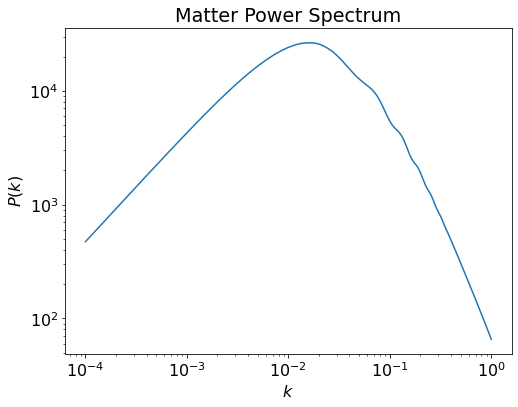

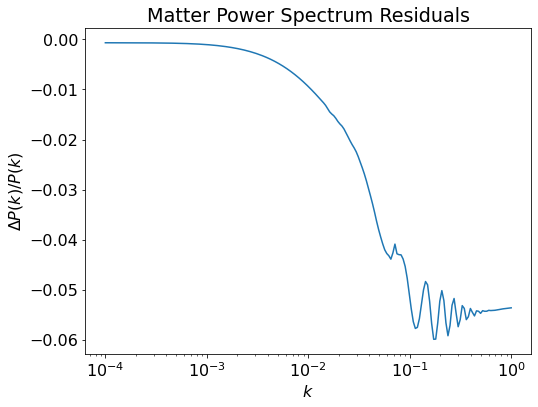

In [40]:
for phi in phis:
    plt.plot(scales, phi)
    plt.xlim([0.01,1])
    plt.ylim([-0.01,0.01])
    plt.xscale('log')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$\phi$')
    plt.title('Dark Energy Field')
plt.show()

for omegaphi in omegaphis:
    plt.plot(scales, omegaphi)
    plt.xscale('log')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$\Omega_{DE}$')
    plt.title('Dark Energy Fraction')
plt.show()

# Plotting Cls
for cl in cls:
    plt.plot(cl[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()
# Plotting Cl residuals
for cl in cls:
    plt.plot((cl[2:]-lcdmcls[2:])/lcdmcls[2:])
plt.xscale('log')
plt.title('CMB Temperature Power Spectrum Residuals')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / C_\ell$')
plt.show()
# Plotting Matter power spectra
for pk in pks:
    plt.plot(ks, pk[0,:])
plt.xscale('log')
plt.yscale('log')
plt.title('Matter Power Spectrum')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.show()
# Plotting Pk residuals
for pk in pks:
    plt.plot(ks, (pk[0,:] - lcdmpks[0,:])/lcdmpks[0,:])
plt.xscale('log')
# plt.yscale('log')
plt.title('Matter Power Spectrum Residuals')
plt.xlabel(r'$k$')
plt.ylabel(r'$\Delta P(k) / P(k)$')
plt.show()

In [7]:
print(cls)

[array([ 0.00000000e+000,  0.00000000e+000,  7.49571139e+135, ...,
       -1.52080410e+088, -7.61315996e+087,  5.56718908e+001])]


In [11]:
for cl in cls[0]:
    print(cl)

0.0
0.0
3285.167506333965
3242.643004990761
1240.2010772549686
1557.0142000124836
2197.352180666038
1470.5816823613459
995.3038782249122
969.7682670939326
951.7936799967403
985.5814119491255
2265.618392454961
3256.066797691481
1687.9518923208295
1993.942816336764
2824.978542580055
3561.1519122126606
4176.966768958061
4071.2691021174687
2931.54847277039
2189.2170330425365
3010.84565797979
3764.285958666273
2835.3615823334685
1477.0791152987954
1194.2294059493022
1634.766459172601
2060.295136440854
2047.1661849251075
1519.3964207688252
1475.1159611955109
2644.047893811772
3600.396403964839
3036.2733365221775
2268.1767303985703
2701.10823274902
3477.653492759831
3491.1603485352707
2903.3384484176545
2193.0566055486183
1745.2937500594273
1569.5807052936036
1581.5732682847963
1696.9643778179047
1831.4618293783276
1918.5178723256965
1962.9711307803234
1987.4938229397524
2014.7730237020282
2067.562663117444
2160.900120131822
2278.830287318838
2397.659221096946
2493.7449763363493
2543.46046460

336.962274409065
336.91086661268366
336.8851344627746
336.88439476784237
336.9087071714167
336.9566456469774
337.0282699331566
337.1236401489979
337.24058800357227
337.3806593810758
337.5416859905796
337.72298521120484
337.92536009212245
338.14738517742865
338.38912068126956
338.64914114774115
338.9275067909895
339.2227921551109
339.5358002892763
339.86510573758176
340.2100258791485
340.56987809309743
340.9447225935748
341.33387675970164
341.73591513557403
342.1508979353381
342.5781425381149
343.01696632302554
343.46668666919123
343.92736379075785
344.39757223182164
344.87737220652855
345.36608109399987
345.86375910838154
346.3682379587447
346.8795778592355
347.3985818590249
347.92233883215914
348.4516518278092
348.98583822509624
349.52421540314134
350.0661007410655
350.61081161798995
351.1584082480607
351.7082080103989
352.25878544910057
352.81020077831187
353.36251421217884
353.91355745977256
354.4648764052892
355.01355992277485
355.56115389642554
356.1062328703373
356.64737138860636